In [8]:
import torch                                                   # root package
import numpy as np                                             # numpy

import pretty_midi                                             # package for preprocessing midi 


import librosa.display

import matplotlib.pyplot as plt

import sys
import IPython.display as ipd

import math

import scipy

import pandas as pd


In [9]:
#Setup the model
##########################

use_cuda = torch.cuda.is_available()
print(use_cuda)
torch.manual_seed(12)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 7, 'pin_memory': True} if use_cuda else {}

torch.cuda.set_device(1)

True


In [10]:
#Function which takes in midi data and converts to input matrix for our input
def create_input_matrix(midi_data, input_length, fs):
    #Create numpy arrays for note onsets, durations, velocities, pitches
    note_onsets = np.zeros(0)
    note_durations = np.zeros(0)
    note_velocities = np.zeros(0)
    note_pitches = np.zeros(0)
    
    truncated_midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    
    #first_note = True
    trim = 0
    
   # print(midi_data.instruments[0].notes[0].start)
    trim = midi_data.instruments[0].notes[0].start
    #Loop through instruments in midi_data
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                note.start = note.start - trim
                note.end = note.end - trim
                if (note.start < input_length):
                    note_onsets = np.append(note_onsets, note.start)
                    note_durations = np.append(note_durations, note.get_duration())
                    note_velocities = np.append(note_velocities, note.velocity)
                    note_pitches = np.append(note_pitches, note.pitch)
                    
                    piano.notes.append(note)
                    
    truncated_midi.instruments.append(piano)
    
    #Quantize note onsets to discrete time steps
    note_onsets = (note_onsets*fs)
    note_onsets = np.floor(note_onsets)
    note_onsets = note_onsets.astype(int)
    
    #note_onsets = note_onsets - note_onsets[0]
    
    #Quantize note durations to discrete time steps
    note_durations = (note_durations*fs)
    note_durations = np.floor(note_durations)
    note_durations = note_durations.astype(int)

    #Convert midi notes to pitches
    note_pitches = note_pitches.astype(int)
    note_pitches = note_pitches - 24
    
    #Calculate the total length of the midi and convert to discrete time steps
    #midi_duration = (int)(midi_data.get_end_time())
    #midi_duration = midi_duration * fs + np.max(note_durations)
    matrix_length = math.ceil((fs * input_length))
    
    onsets = np.zeros((88,matrix_length))
    frames = np.zeros((88,matrix_length))

    for i in range (0, note_pitches.shape[0]):
        onsets[note_pitches[i], note_onsets[i]] = note_velocities[i]
        for j in range(0, note_durations[i]):
            if (note_onsets[i] + j >= matrix_length):
                continue
            else:
                frames[note_pitches[i], note_onsets[i] + j] = note_velocities[i]
            
    #print(np.count_nonzero(onsets))
    #print(np.count_nonzero(frames))
    input_matrix = np.concatenate((onsets, frames))
    return input_matrix, truncated_midi

#Function which takes in a piano roll array and plots it
def plot_piano_roll(piano_roll_array, pitch1, pitch2, fs = 100):
    librosa.display.specshow(piano_roll_array,
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(pitch1))

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Mel2Mel(nn.Module):
    def __init__(self,embedding_dimensions, constant_weight=None):
        super(Mel2Mel, self).__init__()
        
        self._embedding_dimensions = embedding_dimensions
        self.embedding_transformation = nn.Linear(num_patches, self._embedding_dimensions, bias = False)
        
        self.tdd = nn.Conv2d(1, 256, (176, 1))
        
        self.gamma1 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        self.beta1 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        
        self.blstm = nn.LSTM(input_size = 256, hidden_size = 128, bidirectional = True)
        
        self.gamma2 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        self.beta2 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        
        self.tdd2 = nn.Conv2d(1, 80, (256, 1))

    def forward(self, x, instrument_label):

        # Add channel dimension to input
        x = x.unsqueeze(1) 
        
        #Send input through first time distributed dense layer and apply ReLU non-linearity
        x = F.relu(self.tdd(x)) 
        
        # Permute to change order to [Time, Batch, Channel, Pitch]
        x = x.permute(3,0,1,2)
        # Flatten to create "features", new shape [Time, Batch, Features (Pitch*Channel)]
        x = torch.flatten(x,2,3)
        
        # FiLM LAYER
        instrument_label = instrument_label.squeeze()
        #Send the batch of instrument lables through the embedding transformation layer to extract the embedding vector
        embedding_vector = self.embedding_transformation(instrument_label)
        gamma1 = self.gamma1(embedding_vector)
        beta1 = self.beta1(embedding_vector)       
        
        #Apply feature wise transformation  or FiLM-ing      
        x = gamma1*x + beta1
        
        
        # BLSTM Layer : Input[Time, Batch, Features (Pitch*Channel)] -> Output[Time, Batch, Features]
        x = self.blstm(x)
      
        # BLSTM outputs a tuple of {output, (hidden states, cell states)}
        # Only use the ouput
        x = x[0]
        
        # FiLM LAYER
        embedding_vector = self.embedding_transformation(instrument_label)
        gamma2 = self.gamma1(embedding_vector)
        beta2 = self.beta1(embedding_vector)
        
        #Apply feature wise transformation 
        x = gamma1*x + beta1
        
        #Permute to get back into a shape 
        x = x.permute(1, 2, 0)
        x = x.unsqueeze(1)
        
        #Send features through final TDD to shape into spectrogram
        x = self.tdd2(x)
        
        # Remove channel dim
        x = x.squeeze()
                
        return x
    
    #This function is used to return the embedding coordinates for a selected instrumetn once the model has trained
    def return_embedding(self, instrument_label):
        
        instrument_label = instrument_label.squeeze()
        embedding_vector = self.embedding_transformation(instrument_label)
        return embedding_vector
   
    #This function skips the embedding transformation layer allows a mel-spectrogram to be
    #generated from a user specified point in the timbre embedding
    def model_with_embedding(self, x, embedding_vector):
        x = x.unsqueeze(1)
        x = F.relu(self.tdd(x)) 
        
        x = x.permute(3,0,1,2)
        
        x = torch.flatten(x,2,3)
        
        # FiLM LAYER
        gamma1 = self.gamma1(embedding_vector)
        beta1 = self.beta1(embedding_vector)        
        
        x = gamma1*x + beta1
        
        x = self.blstm(x)
             
        x = x[0]
        
        # FiLM LAYER
        gamma2 = self.gamma1(embedding_vector)
        beta2 = self.beta1(embedding_vector)
        
        x = gamma1*x + beta1
        
        #Permute to get back into a shape  
        x = x.permute(1, 2, 0)
        x = x.unsqueeze(1)
        x = self.tdd2(x)
        
        # Remove channel dim
        x = x.squeeze()
                
        return x
        
        

In [12]:
num_patches = 12
embedding_dim = 2

model = Mel2Mel(embedding_dim)
model = model.cuda()
model.load_state_dict(torch.load("/homes/lb311/Project/NeuralSynthesisModel2D"))

<All keys matched successfully>

In [13]:
def tcc(X, Y):
    assert X.shape == Y.shape
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(Y, pd.DataFrame):
        Y = Y.to_numpy()
        
    numer = (X * Y).sum()
    denom = np.sqrt(np.sum(X ** 2) * np.sum(Y ** 2))
    return numer / denom

def protest(X, Y, n_iters=10000):
    idxs = np.arange(Y.shape[0])
    m2s = []
    for n in range(n_iters):
        p = np.random.permutation(idxs)
        Y_ = Y[p]
        _, _, m2 = scipy.spatial.procrustes(X, Y_)
        m2s.append(m2)
    return {
        "mean": np.mean(m2s),
        "p<0.05": np.percentile(m2s, 5),
        "p<0.01": np.percentile(m2s, 1),
        "p<0.001": np.percentile(m2s, 0.1)
    }

def ssq(X):
    return np.sum(np.sum(X))

def rv_mod(X, Y):
    X = X - X.mean()
    Y = Y - Y.mean()
    AA = X @ X.T
    BB = Y @ Y.T
    AA0 = AA - np.diag(np.diag(AA), 0)
    BB0 = BB - np.diag(np.diag(BB), 0)
    RV = np.trace(AA0 @ BB0) / (ssq(AA0 ** 2) ** 0.5) / (ssq(BB0 ** 2) ** 0.5)
    return RV

In [7]:
em2D_coordinates = torch.zeros([num_patches, embedding_dim])
for i in range (0,num_patches):
    instrument_label_vector = torch.zeros([num_patches, 1], dtype=torch.float32)
    instrument_label_vector[i, 0] = 1
    instrument_label_vector = instrument_label_vector.cuda()
    embedding_coord = model.return_embedding(instrument_label_vector)
    em2D_coordinates[i,:] = embedding_coord.detach()
    

fa2D_coordinates = torch.tensor([
    [-1.237299315,-0.061144625],
    [-0.848208307,0.759562987],
    [0.93336706,-1.103981206],
    [0.215467772,-1.064831206],
    [-1.08262181,1.133511071],
    [-1.214043863,0.993489051],
    [1.118323293,0.225895828],
    [0.123741841,-0.635842831],
    [0.402681804,0.788468901],
    [0.675635099,-0.785967793],
    [0.148131692,-1.168043055],
    [0.764824734,0.918882879]])



em2D_coordinates = em2D_coordinates.numpy()
fa2D_coordinates = fa2D_coordinates.numpy()

#Monte carlo permutation test to test the significance of m^2 metric from procrustes
print(protest(em2D_coordinates,fa2D_coordinates))


D, Z, m_squared = scipy.spatial.procrustes(em2D_coordinates,fa2D_coordinates);

r_squared = 1 - m_squared
r = np.sqrt(r_squared)

print("D =")
print(D)
print("Z =")
print(Z)
print(f"m_squared = {m_squared}")
print(f"r_squared = {r_squared}")
print(f"r = {r}")


d1 = scipy.spatial.distance.pdist(Z)
d2 = scipy.spatial.distance.pdist(em2D_coordinates)

CC = tcc(d1,d2);

print(f"CC = {CC}")

#compute RV coefficient between emb2D and transformed fa2D space
RVmod = rv_mod(D, Z)

print(f"RVmod = {RVmod}")

X1 = scipy.stats.pearsonr(em2D_coordinates[:,0],Z[:,0])
X2 = scipy.stats.pearsonr(em2D_coordinates[:,0],Z[:,1])
X3 = scipy.stats.pearsonr(em2D_coordinates[:,1],Z[:,0])
X4 = scipy.stats.pearsonr(em2D_coordinates[:,1],Z[:,1])

X1 = scipy.stats.pearsonr(em2D_coordinates[:,0],fa2D_coordinates[:,0])
X2 = scipy.stats.pearsonr(em2D_coordinates[:,0],fa2D_coordinates[:,1])
X3 = scipy.stats.pearsonr(em2D_coordinates[:,1],fa2D_coordinates[:,0])
X4 = scipy.stats.pearsonr(em2D_coordinates[:,1],fa2D_coordinates[:,1])
print(X1[0])
print(X2[0])
print(X3[0])
print(X4[0])

{'mean': 0.86631948003231973, 'p<0.05': 0.69529927476421238, 'p<0.01': 0.599823676321665, 'p<0.001': 0.51325744414160834}
D =
[[-0.12018426  0.0894102 ]
 [-0.08370919  0.1584708 ]
 [ 0.20471584 -0.51080347]
 [ 0.15399836  0.16889808]
 [-0.2072138   0.13313835]
 [-0.23532909  0.21574563]
 [-0.01855727  0.02415563]
 [-0.06831237 -0.19516729]
 [-0.11298105  0.04083576]
 [ 0.32244068 -0.17719392]
 [ 0.38854828  0.15281602]
 [-0.22341613 -0.10030578]]
Z =
[[ 0.00462507  0.2222272 ]
 [-0.14057744  0.14823611]
 [ 0.20278648 -0.16174441]
 [ 0.19208541 -0.03318739]
 [-0.20884771  0.18836241]
 [-0.18440785  0.21265104]
 [-0.03478354 -0.20173284]
 [ 0.11467477 -0.01893469]
 [-0.13935074 -0.07626341]
 [ 0.14442875 -0.11714919]
 [ 0.21025168 -0.02058145]
 [-0.16088487 -0.14188338]]
m_squared = 0.4393740279428233
r_squared = 0.5606259720571767
r = 0.7487496057142045
CC = 0.8843608538142488
RVmod = 0.6832750424987829
0.478958790276
-0.872701406545
-0.616387665215
0.422590578701


Piano roll shape = (176, 512)


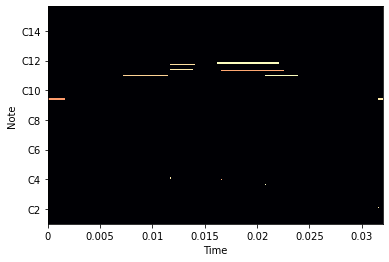

In [8]:
#Load Midi file
midi_file = '/homes/lb311/Project/test_midi/test_midi3.midi'

#Convert midi file to midi data using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_file)

input_matrix, short_midi = create_input_matrix(midi_data, 4.096, 125)

print(f"Piano roll shape = {input_matrix.shape}")
plot_piano_roll(input_matrix, 24, 88, 16000)

input_matrix = torch.from_numpy(input_matrix)
embedding_selection = torch.Tensor([0,0])

input_matrix = input_matrix.unsqueeze(0).float().cuda()
embedding_selection = embedding_selection.unsqueeze(0).float().cuda()



In [9]:
output = model.model_with_embedding(input_matrix, em2D_coordinates)
spec = librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max)
plt.imshow(spec,aspect='auto', origin='lower')
plt.colorbar()


AttributeError: 'numpy.ndarray' object has no attribute 'dim'

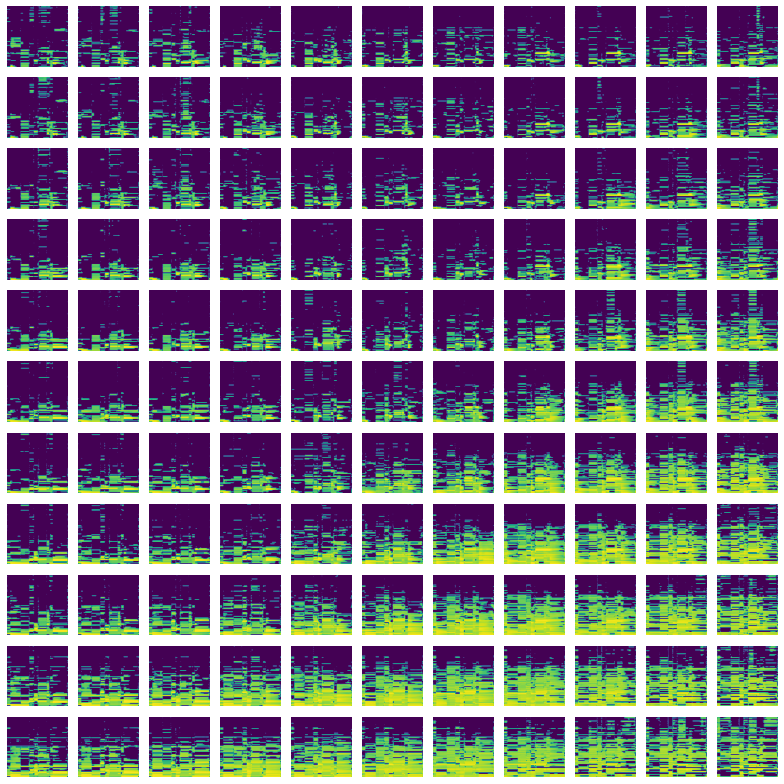

In [10]:
dim1_steps = torch.linspace(-1,1,11)
dim2_steps = torch.linspace(1,-1,11)

fig = plt.figure(figsize=(11, 11))

columns = 11
rows = 11

example = 1
for step2 in dim2_steps:    
    
    for step1 in dim1_steps:
        embedding_selection[0,0] = step1
        embedding_selection[0,1] = step2
        
        output = model.model_with_embedding(input_matrix, embedding_selection)
        # Let's look at the spectrogram of one test sample
        spec = librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max)
        fig.add_subplot(rows, columns, example)
        plt.imshow(spec,aspect='auto', origin='lower')
        plt.axis('off')
       # plt.title(f"{step1:.2}, {step2:.2}", loc = 'left')
        example += 1
        #plt.savefig(f"mel_predictions/{step1}-{step2}.png")

fig.tight_layout()
plt.savefig(f"mel_predictions/grid.png") 

In [ ]:
dim1_steps = torch.linspace(-1,1,11)
dim2_steps = torch.linspace(1,-1,11)

fig = plt.figure(figsize=(11, 11))

columns = 11
rows = 11

example = 1
    
step1 = 0.0
step2 = 0.0

for step1 in dim1_steps:
    embedding_selection[0,0] = step1
    embedding_selection[0,1] = step2

    output = model.model_with_embedding(input_matrix, embedding_selection)
    # Let's look at the spectrogram of one test sample
    spec = librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max)
    fig.add_subplot(rows, columns, example)
    plt.imshow(spec,aspect='auto', origin='lower')
    plt.axis('off')
    plt.title(f"{step1:.2}, {step2:.2}", loc = 'left')
    example += 1
    #plt.savefig(f"mel_predictions/{step1}-{step2}.png")

fig.tight_layout()
plt.savefig(f"mel_predictions/grid.png") 

[[-0.3756107   0.36441898]
 [-0.32757887  0.45536074]
 [ 0.05223071 -0.42596632]
 [-0.01455609  0.4690918 ]
 [-0.49021468  0.42200196]
 [-0.527238    0.5307825 ]
 [-0.24178423  0.27848917]
 [-0.30730373 -0.010324  ]
 [-0.36612523  0.30045423]
 [ 0.20725548  0.01334404]
 [ 0.2943086   0.4479143 ]
 [-0.51155055  0.11459342]]


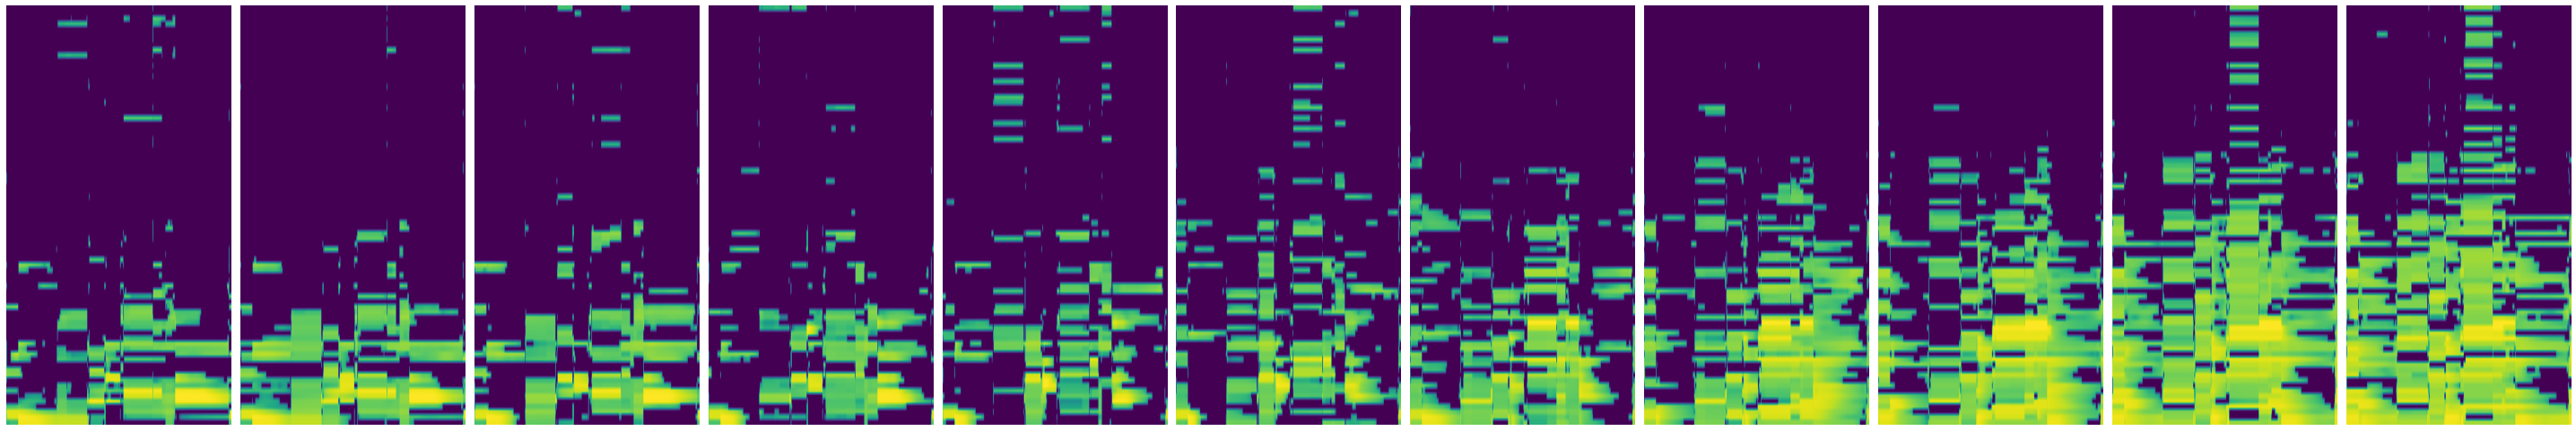

In [12]:
print(em2D_coordinates)
dim1_steps = torch.linspace(-1,1,11)
dim2_steps = torch.linspace(1,-1,11)

fig = plt.figure(figsize=(40, 40))

columns = 11
rows = 6

example = 1
    
step1 = 0.0
step2 = 0.0

 
    
for step in enumerate(dim1_steps):
    
    embedding_selection[0,0] = dim1_steps[step[0]]
    embedding_selection[0,1] = 0.0

    output = model.model_with_embedding(input_matrix, embedding_selection)
    # Let's look at the spectrogram of one test sample
    spec = librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max)
    fig.add_subplot(rows, columns, example)
    plt.imshow(spec,aspect='auto', origin='lower')
    plt.axis('off')
   # plt.title(f"{step1:.2}, {step2:.2}", loc = 'left')
    example += 1
    #plt.savefig(f"mel_predictions/{step1}-{step2}.png")

fig.tight_layout()
plt.savefig(f"mel_predictions/grid.png") 